In [3]:
from __future__ import print_function
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
import keras
from keras import metrics
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam, RMSprop
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.utils import plot_model
from keras.models import load_model

Load data from CSV file and define the label column.

In [5]:
kc_data_org = pd.read_csv("https://raw.githubusercontent.com/jiadai777/predict-housing-price-project/master/kc_house_data.csv")
kc_data_org.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


Transform dates into year, month and day and select columns.

In [6]:
kc_data_org['sale_yr'] = pd.to_numeric(kc_data_org.date.str.slice(0, 4))
kc_data_org['sale_month'] = pd.to_numeric(kc_data_org.date.str.slice(4, 6))
kc_data_org['sale_day'] = pd.to_numeric(kc_data_org.date.str.slice(6, 8))

kc_data = pd.DataFrame(kc_data_org, columns=[
        'sale_yr','sale_month','sale_day',
        'bedrooms','bathrooms','sqft_living','sqft_lot','floors',
        'condition','grade','sqft_above','sqft_basement','yr_built',
        'zipcode','lat','long','sqft_living15','sqft_lot15','price'])
label_col = 'price'

print(kc_data.describe())

            sale_yr    sale_month      sale_day      bedrooms     bathrooms  \
count  21613.000000  21613.000000  21613.000000  21613.000000  21613.000000   
mean    2014.322954      6.574423     15.688197      3.370842      2.114757   
std        0.467616      3.115308      8.635063      0.930062      0.770163   
min     2014.000000      1.000000      1.000000      0.000000      0.000000   
25%     2014.000000      4.000000      8.000000      3.000000      1.750000   
50%     2014.000000      6.000000     16.000000      3.000000      2.250000   
75%     2015.000000      9.000000     23.000000      4.000000      2.500000   
max     2015.000000     12.000000     31.000000     33.000000      8.000000   

        sqft_living      sqft_lot        floors     condition         grade  \
count  21613.000000  2.161300e+04  21613.000000  21613.000000  21613.000000   
mean    2079.899736  1.510697e+04      1.494309      3.409430      7.656873   
std      918.440897  4.142051e+04      0.539989    

### Split data for training and validation
Function to split a range of data frame / array indeces into three sub-ranges.

In [7]:
def train_validate_test_split(df, train_part=.6, validate_part=.2, test_part=.2, seed=None):
    np.random.seed(seed)
    total_size = train_part + validate_part + test_part
    train_percent = train_part / total_size
    validate_percent = validate_part / total_size
    test_percent = test_part / total_size
    perm = np.random.permutation(df.index)
    m = len(df)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = perm[:train_end]
    validate = perm[train_end:validate_end]
    test = perm[validate_end:]
    return train, validate, test

Split index ranges into three parts, however, ignore the third.

In [8]:
train_size, valid_size, test_size = (70, 30, 0)
kc_train, kc_valid, kc_test = train_validate_test_split(kc_data, 
                              train_part=train_size, 
                              validate_part=valid_size,
                              test_part=test_size,
                              seed=2017)

Extract data for training and validation into x and y vectors.

In [9]:
kc_y_train = kc_data.loc[kc_train, [label_col]]
kc_x_train = kc_data.loc[kc_train, :].drop(label_col, axis=1)
kc_y_valid = kc_data.loc[kc_valid, [label_col]]
kc_x_valid = kc_data.loc[kc_valid, :].drop(label_col, axis=1)

print('Size of training set: ', len(kc_x_train))
print('Size of validation set: ', len(kc_x_valid))
print('Size of test set: ', len(kc_test), '(not converted)')

Size of training set:  15129
Size of validation set:  6483
Size of test set:  1 (not converted)


### Prepare data for training and validation of the Keras model¶
Function to get statistics about a data frame.

In [10]:
def norm_stats(df1, df2):
    dfs = df1.append(df2)
    minimum = np.min(dfs)
    maximum = np.max(dfs)
    mu = np.mean(dfs)
    sigma = np.std(dfs)
    return (minimum, maximum, mu, sigma)

Function to Z-normalise the entire data frame - note stats for Z transform passed in.

In [11]:
def z_score(col, stats):
    m, M, mu, s = stats
    df = pd.DataFrame()
    for c in col.columns:
        df[c] = (col[c]-mu[c])/s[c]
    return df

Normalise training and validation predictors using the stats from training data only (to ensure the same transformation applies to both training and validation data), and then convert them into numpy arrays to be used by Keras.

In [12]:
stats = norm_stats(kc_x_train, kc_x_valid)
arr_x_train = np.array(z_score(kc_x_train, stats))
arr_y_train = np.array(kc_y_train)
arr_x_valid = np.array(z_score(kc_x_valid, stats))
arr_y_valid = np.array(kc_y_valid)

print('Training shape:', arr_x_train.shape)
print('Training samples: ', arr_x_train.shape[0])
print('Validation samples: ', arr_x_valid.shape[0])

Training shape: (15129, 18)
Training samples:  15129
Validation samples:  6483


## Create Keras model
### Three functions to define alternative Keras models

The first is very simple, consisting of three layers and Adam optimizer.

In [13]:
def basic_model_1(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(100, activation="tanh", input_shape=(x_size,)))
    t_model.add(Dense(50, activation="relu"))
    t_model.add(Dense(y_size))
    print(t_model.summary())
    t_model.compile(loss='mean_squared_error',
        optimizer=Adam(),
        metrics=[metrics.mae])
    return(t_model)

The second with Adam optimizer consists of 4 layers and the first uses 10% dropouts.

In [14]:
def basic_model_2(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(100, activation="tanh", input_shape=(x_size,)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(50, activation="relu"))
    t_model.add(Dense(20, activation="relu"))
    t_model.add(Dense(y_size))
    print(t_model.summary())
    t_model.compile(loss='mean_squared_error',
        optimizer=Adam(),
        metrics=[metrics.mae])
    return(t_model)

The third is the most complex, it extends the previous model with nadam optimizer, dropouts and L1/L2 regularisers.

In [15]:
def basic_model_3(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(80, activation="tanh", kernel_initializer='normal', input_shape=(x_size,)))
    t_model.add(Dropout(0.2))
    t_model.add(Dense(120, activation="relu", kernel_initializer='normal', 
        kernel_regularizer=regularizers.l1(0.01), bias_regularizer=regularizers.l1(0.01)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(20, activation="relu", kernel_initializer='normal', 
        kernel_regularizer=regularizers.l1_l2(0.01), bias_regularizer=regularizers.l1_l2(0.01)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(10, activation="relu", kernel_initializer='normal'))
    t_model.add(Dropout(0.0))
    t_model.add(Dense(y_size))
    t_model.compile(
        loss='mean_squared_error',
        optimizer='nadam',
        metrics=[metrics.mae])
    return(t_model)

Now create each of the model separately.

In [16]:
model1 = basic_model_1(arr_x_train.shape[1], arr_y_train.shape[1])
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               1900      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 7,001
Trainable params: 7,001
Non-trainable params: 0
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               1900      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
den

In [17]:
model2 = basic_model_2(arr_x_train.shape[1], arr_y_train.shape[1])
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 100)               1900      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_6 (Dense)              (None, 20)                1020      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 21        
Total params: 7,991
Trainable params: 7,991
Non-trainable params: 0
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
den

In [18]:
model3 = basic_model_3(arr_x_train.shape[1], arr_y_train.shape[1])
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 80)                1520      
_________________________________________________________________
dropout_2 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 120)               9720      
_________________________________________________________________
dropout_3 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 20)                2420      
_________________________________________________________________
dropout_4 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)                210       
__________

### Fit/Train Keras model
Define how many epochs of training should be done and what is the batch size.

In [19]:
epochs = 500
batch_size = 128

print('Epochs: ', epochs)
print('Batch size: ', batch_size)

Epochs:  500
Batch size:  128


Specify Keras callbacks which allow additional functionality while the model is being fitted.

- ModelCheckpoint allows to save the models as they are being built or improved.
- TensorBoard interacts with TensorFlow interactive reporting system.
- EarlyStopping watches one of the model measurements and stops fitting when no improvement.

In [20]:
keras_callbacks = [
    EarlyStopping(monitor='val_mean_absolute_error', patience=20, verbose=0)
]

Fit the model and record the history of each training and validation.
As we specified EarlyStopping with patience=20, with luck the training will stop in less than 200 epochs.

In [21]:
history1 = model1.fit(arr_x_train, arr_y_train,
    batch_size=batch_size,
    epochs=epochs,
    shuffle=True,
    verbose=0, # Change it to 2, if wished to observe execution
    validation_data=(arr_x_valid, arr_y_valid),
    callbacks=keras_callbacks)

In [22]:
history2 = model2.fit(arr_x_train, arr_y_train,
    batch_size=batch_size,
    epochs=epochs,
    shuffle=True,
    verbose=0, # Change it to 2, if wished to observe execution
    validation_data=(arr_x_valid, arr_y_valid),
    callbacks=keras_callbacks)

In [23]:
history3 = model3.fit(arr_x_train, arr_y_train,
    batch_size=batch_size,
    epochs=epochs,
    shuffle=True,
    verbose=0, # Change it to 2, if wished to observe execution
    validation_data=(arr_x_valid, arr_y_valid),
    callbacks=keras_callbacks)

### Evaluate and report performance of the trained models

There are many ways of measuring a model’s accuracy. However, the Mean Absolute Error, also known as MAE, is one of the many metrics for summarizing and assessing the quality of a machine learning model according to this article: https://medium.com/@ewuramaminka/mean-absolute-error-mae-machine-learning-ml-b9b4afc63077

In [24]:
train_score = model1.evaluate(arr_x_train, arr_y_train, verbose=0)
valid_score = model1.evaluate(arr_x_valid, arr_y_valid, verbose=0)

print('Train MAE for Model 1: ', round(train_score[1], 4), ', Train Loss: ', round(train_score[0], 4)) 
print('Val MAE for Model 1: ', round(valid_score[1], 4), ', Val Loss: ', round(valid_score[0], 4))

Train MAE for Model 1:  74875.5559 , Train Loss:  22036261602.6
Val MAE for Model 1:  83019.4119 , Val Loss:  31126247257.8


In [25]:
train_score = model2.evaluate(arr_x_train, arr_y_train, verbose=0)
valid_score = model2.evaluate(arr_x_valid, arr_y_valid, verbose=0)

print('Train MAE for Model 2: ', round(train_score[1], 4), ', Train Loss: ', round(train_score[0], 4)) 
print('Val MAE for Model 2: ', round(valid_score[1], 4), ', Val Loss: ', round(valid_score[0], 4))

Train MAE for Model 2:  70446.7127 , Train Loss:  14672045645.2
Val MAE for Model 2:  80604.2576 , Val Loss:  24201994470.1


In [26]:
train_score = model3.evaluate(arr_x_train, arr_y_train, verbose=0)
valid_score = model3.evaluate(arr_x_valid, arr_y_valid, verbose=0)

print('Train MAE for Model 3: ', round(train_score[1], 4), ', Train Loss: ', round(train_score[0], 4)) 
print('Val MAE for Model 3: ', round(valid_score[1], 4), ', Val Loss: ', round(valid_score[0], 4))

Train MAE for Model 3:  71244.5802 , Train Loss:  14805778023.3
Val MAE for Model 3:  79786.503 , Val Loss:  22804619186.9


As we can see, Model 3 validation MAE is smallest. Next, we are going to plot the training history of these three models to further visualize their accuracies.

This function allows plotting of the training history

In [27]:
def plot_hist(h, xsize=6, ysize=10):
    # Prepare plotting
    fig_size = plt.rcParams["figure.figsize"]
    plt.rcParams["figure.figsize"] = [xsize, ysize]
    fig, axes = plt.subplots(nrows=4, ncols=4, sharex=True)
    
    # summarize history for MAE
    plt.subplot(211)
    plt.plot(h['mean_absolute_error'])
    plt.plot(h['val_mean_absolute_error'])
    plt.title('Training vs Validation MAE')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # summarize history for loss
    plt.subplot(212)
    plt.plot(h['loss'])
    plt.plot(h['val_loss'])
    plt.title('Training vs Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot it all in IPython (non-interactive)
    plt.draw()
    plt.show()

    return

Now plot the training history, i.e. the Mean Absolute Error and Loss (Mean Squared Error), which were both defined at the time of model compilation.

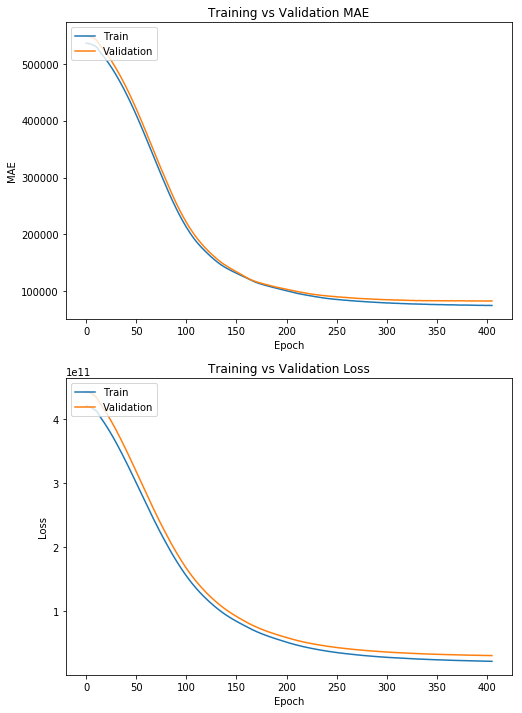

In [28]:
plot_hist(history1.history, xsize=8, ysize=12)

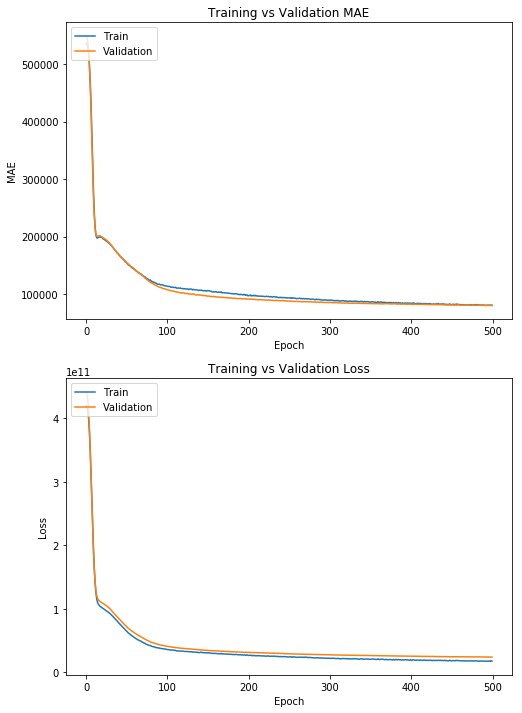

In [29]:
plot_hist(history2.history, xsize=8, ysize=12)

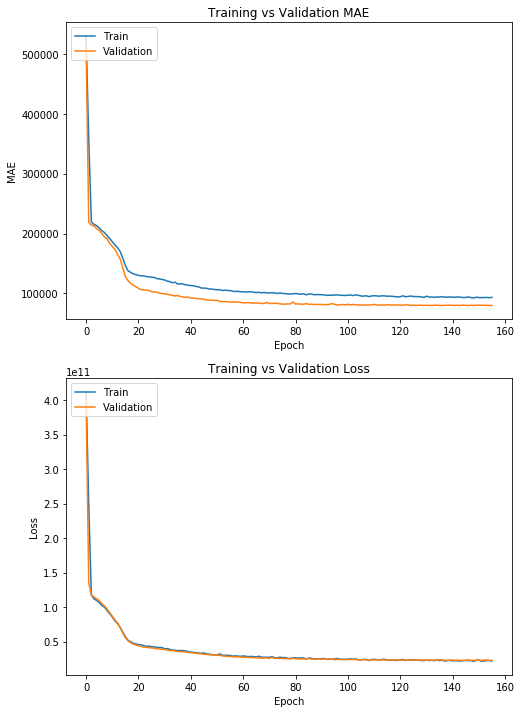

In [30]:
plot_hist(history3.history, xsize=8, ysize=12)

## Conclusion:
The Mean Absolute Error (or MAE) is the average of the absolute differences between predictions and actual values. It gives an idea of how wrong the predictions were.

The measure gives an idea of the magnitude of the error, but no idea of the direction (e.g. over or under predicting). The less it is, the more accurate model we have.

Therefore, Model 3 we created would be a better model for our deep learning prototype as compared to the other two models.